<a href="https://colab.research.google.com/github/JuliaKondratieva/image-segmentation/blob/main/Lab3_RO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
uploaded1 = files.upload()

Saving 1.jpg to 1 (1).jpg


In [ ]:
uploaded2 = files.upload()

Saving 2.jpg to 2 (1).jpg


In [ ]:
image_1 = cv2.imread('1.jpg')
image_2 = cv2.imread('2.jpg')

gray_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
gray_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

**Порогова обробка Оцу**

In [ ]:
def otsu(image):
  image_result, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return otsu_threshold

**Морфлологічна обробка**

In [ ]:
def erode(image_gray):
  kernel = np.ones((5,5), np.uint8)
  return cv2.erode(image_gray, kernel, iterations=1)

In [ ]:
def dilate(image_gray):
  kernel = np.ones((5,5), np.uint8)
  return cv2.dilate(image_gray, kernel, iterations=1)

In [ ]:
def morphEx(image_gray):
  kernel = np.ones((5,5), np.uint8)
  return cv2.morphologyEx(image_gray, cv2.MORPH_OPEN, kernel)

**Гаусовський фільтр**

In [ ]:
def gaussian_blur(image):
  return cv2.GaussianBlur(image,(5,5),3)

In [ ]:
from skimage.metrics import adapted_rand_error
from skimage.metrics import variation_of_information

def metrics(img1, img2):
  arr_a, arr_v = [],[]
  arr_a.append(adapted_rand_error(img1, img2))
  arr_v.append(variation_of_information(img1, img2))
  return arr_a, arr_v

Пікселі, які відносяться до одного сегменту: функція skimage.measure.label.

170


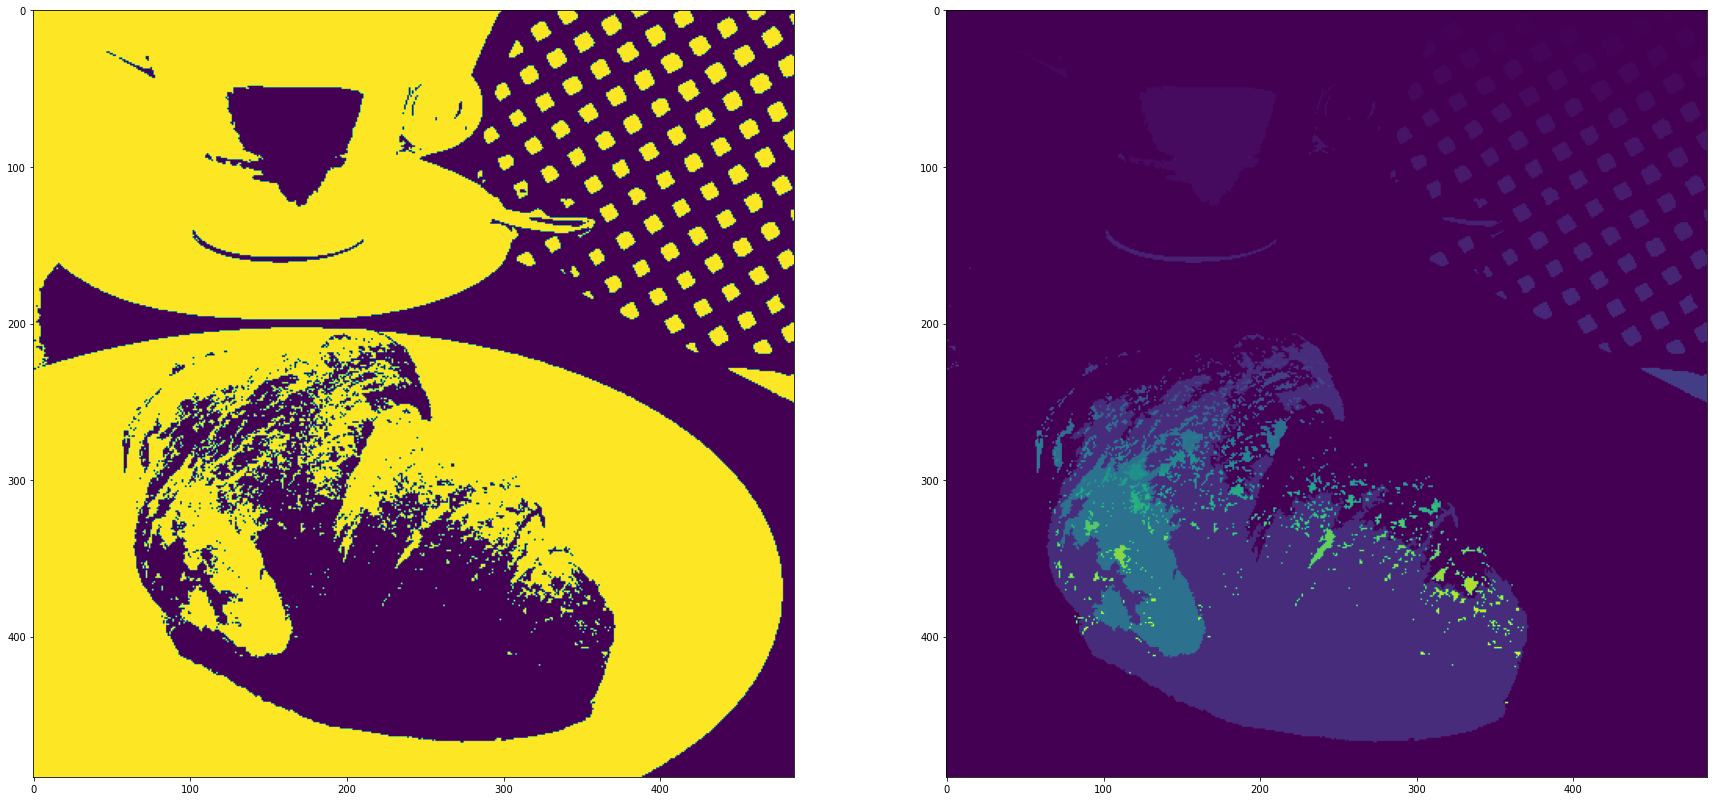

In [ ]:
from skimage.measure import label
from skimage.color import label2rgb
from skimage.measure import regionprops
import matplotlib.patches as mpatches
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.morphology import area_closing, area_opening

fig, ax = plt.subplots(ncols=2, figsize=(30, 50))
#ax = axes.ravel()

thresh = otsu(gray_2)
pix = gray_2
print (pix[0,69])
ax[0].imshow(thresh)

label_im1 = label(thresh, background=250, connectivity=1)
regions = regionprops(label_im1)
ax[1].imshow(label_im1)

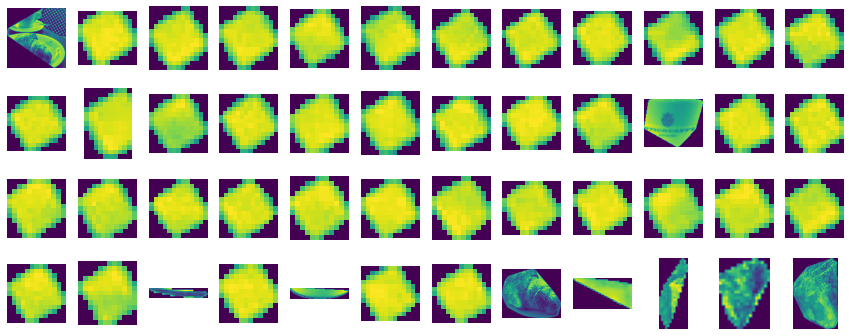

In [ ]:
masks = []
bbox = []
for num, x in enumerate(regions):
    area = x.area
    convex_area = x.convex_area
    if num!=0 and x.area >= 100: 
        masks.append(regions[num].convex_image)
        bbox.append(regions[num].bbox)    
count = len(masks)
fig, axis = plt.subplots(4, int(count/4), figsize=(15,6))
for ax, box, mask in zip(axis.flatten(), bbox, masks):
    image  =  gray_2[box[0]:box[2], box[1]:box[3]] * mask
    ax.imshow(image)
    ax.axis('off')

210


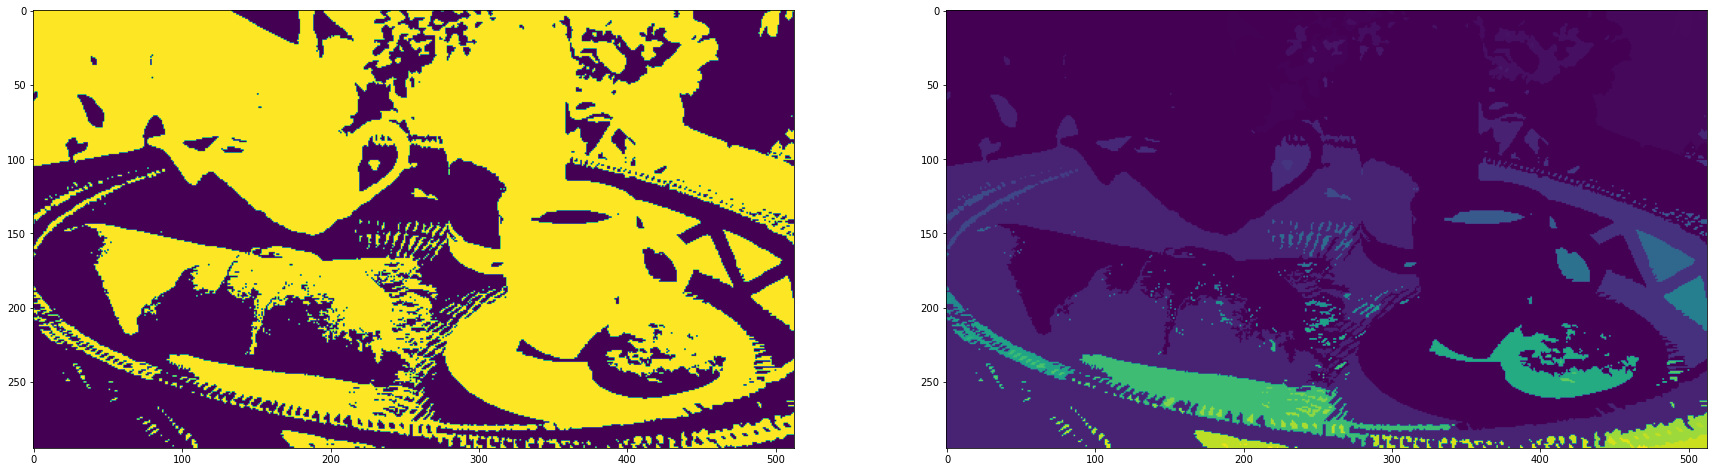

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 50))
#ax = axes.ravel()


thresh1 = otsu(gray_1)
pix = gray_1
print (pix[3,6])
ax[0].imshow(thresh1)

label_im2 = label(thresh1, background=210)
regions = regionprops(label_im2)
ax[1].imshow(label_im2)

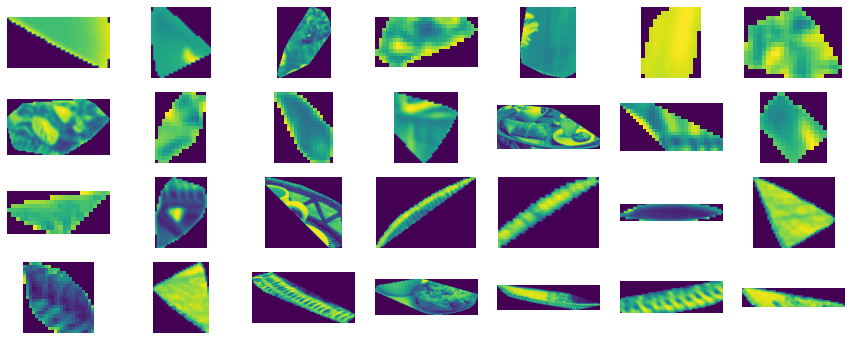

In [ ]:
masks = []
bbox = []
for num, x in enumerate(regions):
    area = x.area
    convex_area = x.convex_area
    if num!=0 and x.area >= 100: 
        masks.append(regions[num].convex_image)
        bbox.append(regions[num].bbox)    
count = len(masks)
fig, axis = plt.subplots(4, int(count/4), figsize=(15,6))
for ax, box, mask in zip(axis.flatten(), bbox, masks):
    image  =  gray_1[box[0]:box[2], box[1]:box[3]] * mask
    ax.imshow(image)
    ax.axis('off')

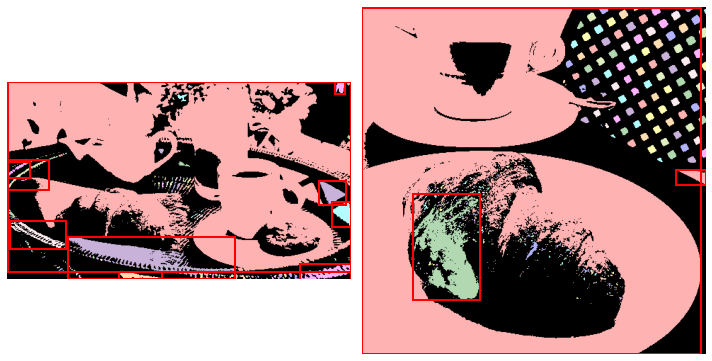

In [ ]:
thresh = otsu(gray_1)

# label image regions
label_image = label(thresh)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=thresh, bg_label=0)

fig, ax = plt.subplots(ncols=2,figsize=(10, 6))
ax[0].imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax[0].add_patch(rect)

ax[0].set_axis_off()
plt.tight_layout()

thresh2 = otsu(gray_2)

# label image regions
label_image2 = label(thresh2, connectivity=1)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay2 = label2rgb(label_image2, image=thresh2, bg_label=0)

ax[1].imshow(image_label_overlay2)

for region in regionprops(label_image2):
    # take regions with large enough areas
    if region.area >= 150:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax[1].add_patch(rect)

ax[1].set_axis_off()
plt.tight_layout()


**Watershed**

Початкові точки вибираються по мінімальних значенях інтенсивності.
При цьому кількість вихідних пікселів (відповідно і областей)
визначається наперед. Нарощування областей відбувається
паралельно, підняттям рівня інтенсивності до тих пір, поки не
встановиться конкуренція по встановленню близькості між сусідніми
областями.

Сегментація вододілу – це метод на основі регіонів, який використовує морфологію зображення. Він вимагає виділення принаймні одного маркера (“початкової” точки) для кожного об’єкта зображення, включаючи фон як окремий об’єкт. Щоб зрозуміти вододіл, можна уявити зображення як поверхню, де яскраві пікселі представляють вершини гір, а темні пікселі — долини. Значення висоти ландшафту зазвичай визначаються значеннями сірого кольору відповідних пікселів або їх величиною градієнта. На основі такого 3D-подання перетворення вододілу розкладає зображення на водозбірні басейни. Для кожного локального мінімуму водозбірний басейн містить усі точки, шлях найкрутішого спуску яких закінчується на цьому мінімумі. Вододіли відокремлюють басейни один від одного. Перетворення вододілу повністю розкладає зображення і, таким чином, призначає кожен піксель або регіону, або вододілу. При наявності шумних даних медичних зображень виникає велика кількість малих областей. Це відомо як проблема «надсегментації».

[(0.6873304063129715, 0.23276769930202143, 0.4760998184239892)] v: [array([4.06915748, 0.91083537])]


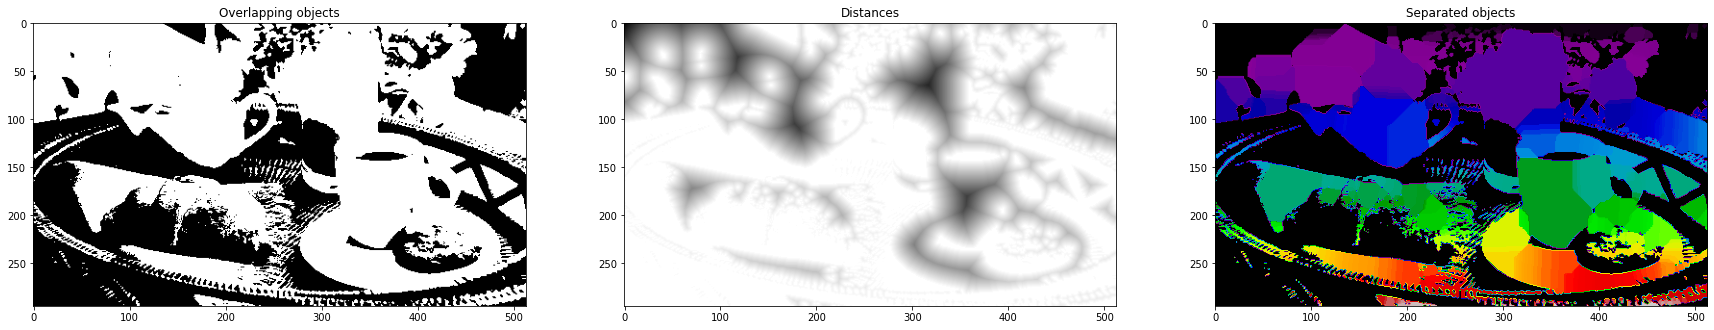

In [ ]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

def wshd(img, label_im):
  # compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this distance map
  distance = ndi.distance_transform_edt(otsu(img))
  coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=otsu(img))
  distance = ndi.distance_transform_edt(otsu(img))

  #allocate memory for the label region and draw it on the mask
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers, _ = ndi.label(mask)
  labels = watershed(-distance, markers, mask=otsu(img))

  fig, axes = plt.subplots(ncols=3, figsize=(30, 50))
  ax = axes.ravel()

  ax[0].imshow(otsu(img), cmap=plt.cm.gray)
  ax[0].set_title('Overlapping objects')
  ax[1].imshow(-distance, cmap=plt.cm.gray)
  ax[1].set_title('Distances')
  ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
  ax[2].set_title('Separated objects')
  array_metr1, array_metr2 = metrics(label_im, labels)
  return array_metr1, array_metr2

watershed_are_1, watershed_voi_1 = wshd(gray_1, label_im2)
print(watershed_are_1, "v:", watershed_voi_1)

[(0.684094664105614, 0.2345585435506226, 0.48363323898839433)] v: [array([3.43790707, 0.63520857])]


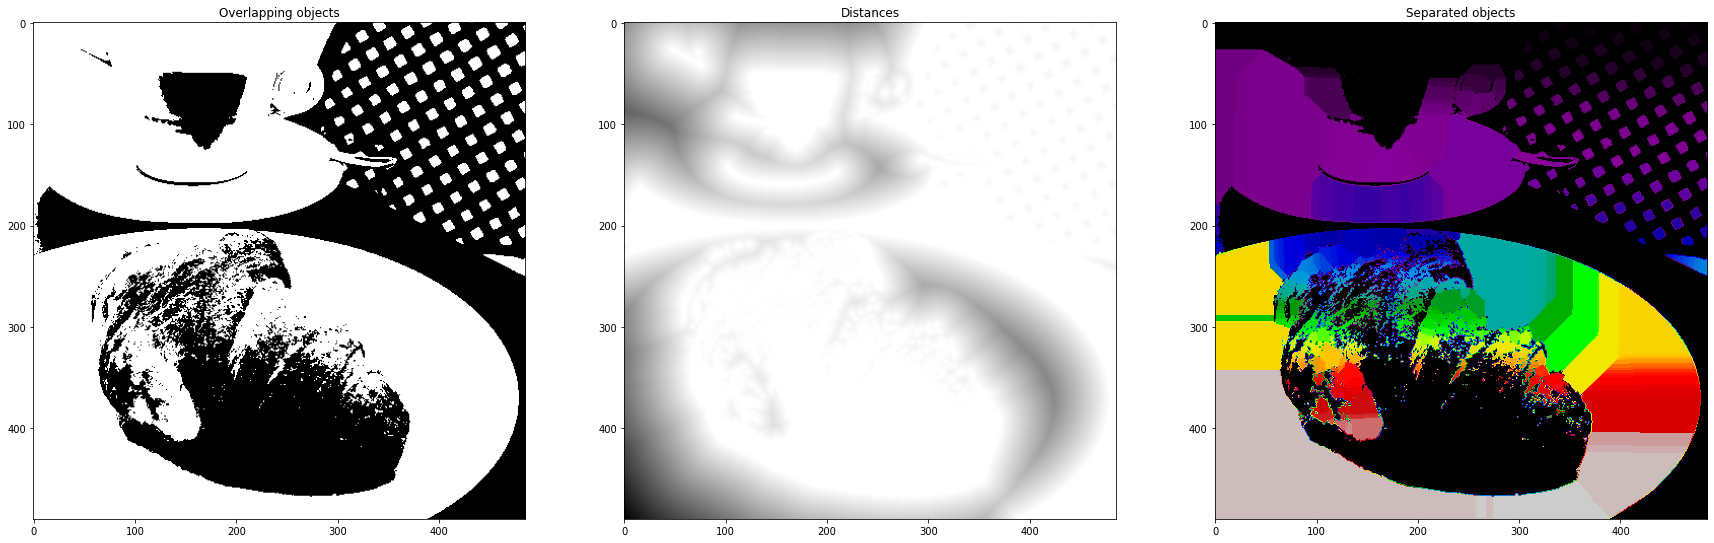

In [ ]:
watershed_are_2, watershed_voi_2=wshd(gray_2,label_im1)
print(watershed_are_2, "v:", watershed_voi_2)

The first step in applying the watershed algorithm for segmentation is to compute the Euclidean Distance Transform (EDT) via the distance_transform_edt function. As the name suggests, this function computes the Euclidean distance to the closest zero (i.e., background pixel) for each of the foreground pixels. We can visualize the EDT in the figure below:

Then we take D , our distance map, and find peaks (i.e., local maxima) in the map.

Since the watershed algorithm assumes our markers represent local minima (i.e., valleys) in our distance map, we take the negative value of D .

The watershed function returns a matrix of labels , a NumPy array with the same width and height as our input image. Each pixel value as a unique label value. Pixels that have the same label value belong to the same object.

The last step is to simply loop over the unique label values and extract each of the unique objects:

**Flood Fill**

За допомогою алгоритма затоплення, (FloodFill,Seed
Fill) можна виділити однорідні за кольором регіони.
Для цього потрібно вибрати початковий піксель і
задати інтервал зміни кольору сусідніх пікселів щодо
вихідного. Алгоритм буде об'єднувати пікселі в один
сегмент (заливаючи їх одним кольором), якщо вони
потрапляють в зазначений діапазон. На виході буде
сегмент, залитий певним кольором, і його площа в
пікселях.

(295, 513)


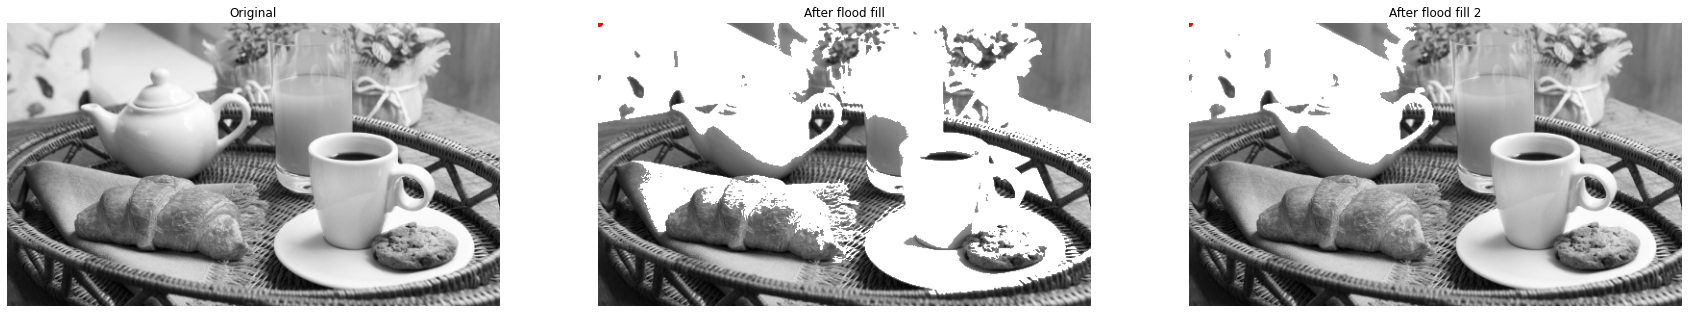

[(0.17120667312283833, 0.7094112795505894, 0.9964850932668494)] v: [array([3.27434532, 0.97606336])]


In [ ]:
# Change the cameraman's coat from dark to light (255).  The seed point is
# chosen as (155, 150)
from skimage.segmentation import flood_fill

light_layer = flood_fill((gray_1), (0, 0), 255, tolerance=60)
light_layer_2 = flood_fill((gray_1), (0, 0), 255, tolerance=50)
print(light_layer.shape)
fig, ax = plt.subplots(ncols=3, figsize=(30, 50))

ax[0].imshow((gray_1), cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(light_layer, cmap=plt.cm.gray)
ax[1].plot(0, 0, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

ax[2].imshow(light_layer_2, cmap=plt.cm.gray)
ax[2].plot(0, 0, 'ro')  # seed point
ax[2].set_title('After flood fill 2')
ax[2].axis('off')

plt.show()
floodfill_are_1, floodfill_voi_1 = metrics(label_im2, light_layer)
print(floodfill_are_1, "v:", floodfill_voi_1)

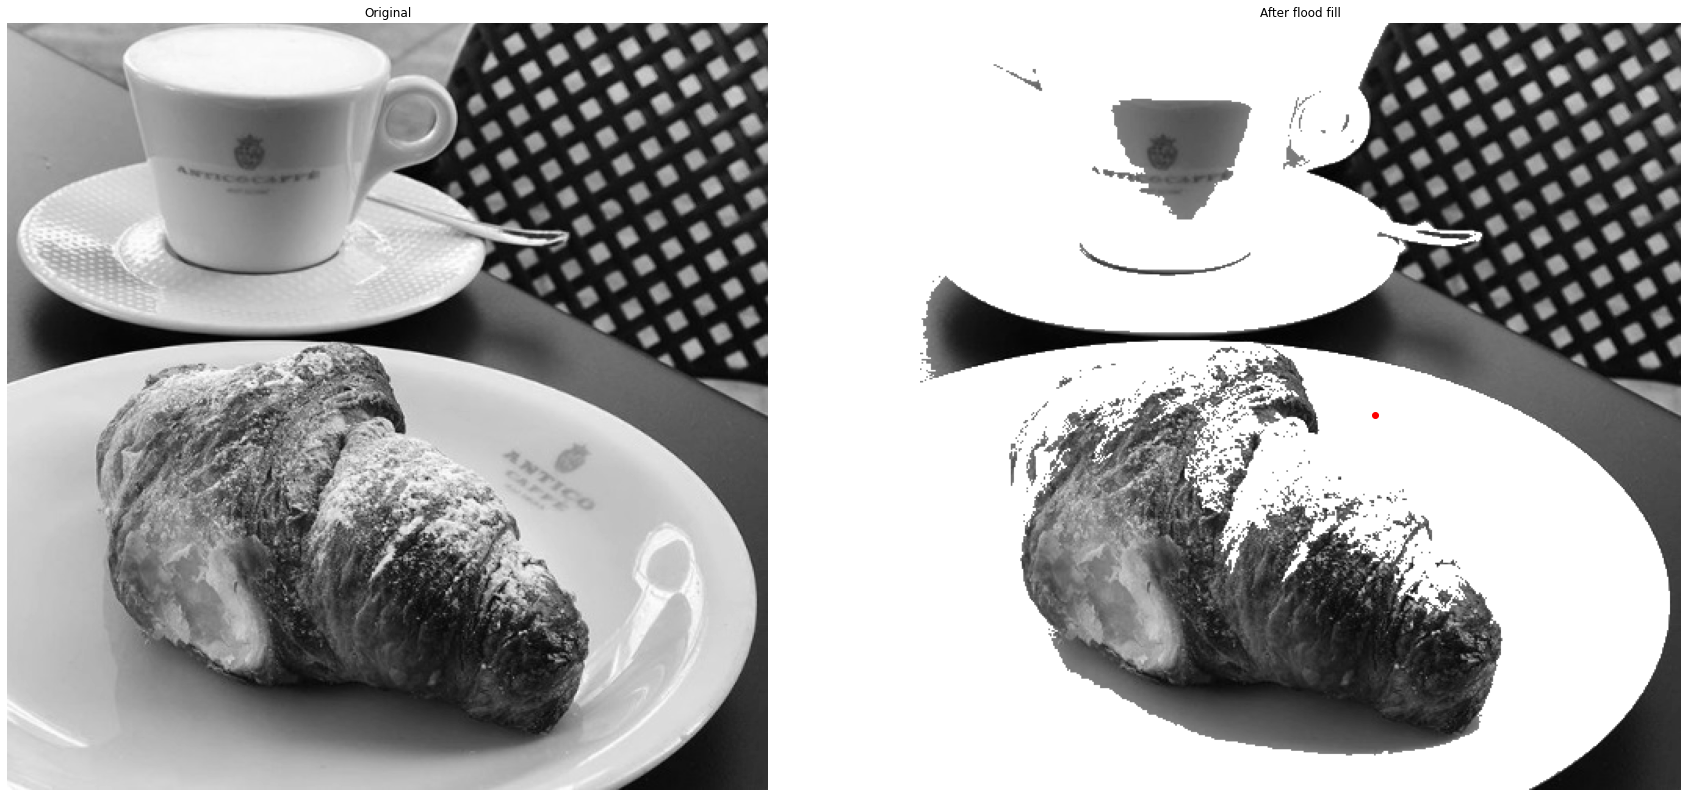

[(0.11783211355170842, 0.7958158330678217, 0.98954053971424)] v: [array([2.95775628, 0.8496336 ])]


In [ ]:
light_layer = flood_fill((gray_2), (290, 250), 255, tolerance=80)

fig, ax = plt.subplots(ncols=2, figsize=(30, 50))

ax[0].imshow((gray_2), cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(light_layer, cmap=plt.cm.gray)
ax[1].plot(290, 250, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()
floodfill_are_2, floodfill_voi_2 = metrics(label_im1, light_layer)
print(floodfill_are_2, "v:", floodfill_voi_2)

Because standard flood filling requires the neighbors to be strictly equal, its use is limited on real-world images with color gradients and noise. The tolerance keyword argument widens the permitted range about the initial value, allowing use on real-world images.

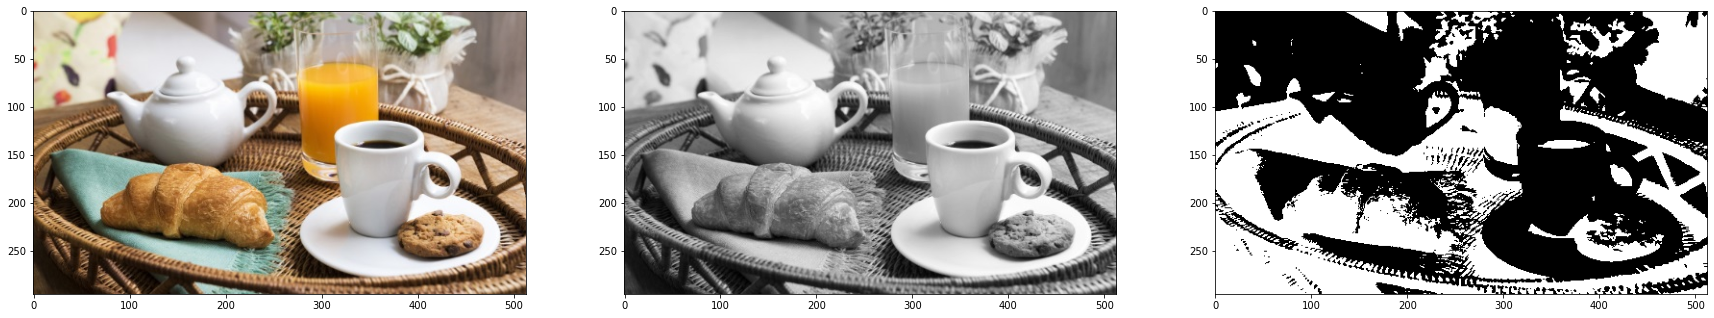

In [ ]:
rgb_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

# Read image
im_in = gray_1
# Threshold.
# Set values equal to or above 220 to 0.
# Set values below 220 to 255.
im_th = otsu(gray_1)
# Copy the thresholded image.
im_floodfill = im_th.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255)
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = im_th | im_floodfill_inv
fig, ax = plt.subplots(figsize=(30, 50))

# Display images.
plt.subplot(1, 3, 1) 
plt.imshow(rgb_1)
plt.subplot(1, 3, 2) 
plt.imshow(gray_1, cmap="gray")
plt.subplot(1, 3, 3) 
plt.imshow(im_floodfill_inv,cmap="gray")
plt.show() 




We know the pixel (0,0) is connected to the background. So we can extract the background, by simply doing a floodfill operation from pixel (0, 0). Pixels that are not affected by the floodfill operation are necessarily inside the boundary.

**GrabCut**

Алгоритм GrabCut :
• Обирає вхідне зображення або (1) обмежувальною
рамкою , що зазначає розташування об'єкта на
зображенні в якості бажаного сегмента або (2) маски ,
яка апроксимує сегментацію
• Покроково:
– Крок 1. Оцінка розподілу кольорів переднього та
заднього планів за допомогою моделі Гаусової суміші
(GMM)
– Крок No2: Побудова випадкового поля Маркова над
мітками пікселів (тобто, передній план проти фону)
– Крок No3: Застосування оптимізації вирізання графів
для досягнення остаточної сегментації

grabCut(img, mask, rect, bgdModel, fgdModel, iterCount[, mode]) ->
	mask, bgdModel, fgdModel

img: The input image, which GrabCut assumes to be an 8-bit, 3-channel image (i.e., unsigned 8-bit integer in BGR channel ordering).
mask: The input/output mask. This mask is assumed to be a single-channel image with an unsigned 8-bit integer data type. This mask is initialized automatically if you use bounding box initialization (i.e., cv2.GC_INIT_WITH_RECT); otherwise, GrabCut assumes you are performing mask initialization (cv2.GC_INIT_WITH_MASK).
rect: The bounding box rectangle that contains the region that we want to segment. This parameter is only used when you set the mode to cv2.GC_INIT_WITH_MASK).
bgModel: Temporary array used by GrabCut internally when modeling the background.
fgModel: Temporary array used by GrabCut when modeling the foreground.
iterCount: Number of iterations GrabCut will perform when modeling the foreground versus background. The more iterations, the longer GrabCut will run, and ideally the results will be better.
mode: Either cv2.GC_INIT_WITH_RECT or cv2.GC_INIT_WITH_MASK, depending on whether you are initializing GrabCut with a bounding box or a mask, respectively.
OpenCV’s GrabCut implementation returns a 3-tuple of:

mask: The output mask after applying GrabCut
bgModel: The temporary array used to model the background (you can ignore this value)
fgModel: The temporary array for the foreground (again, you can ignore this value)


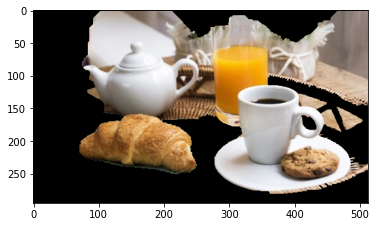

In [ ]:
rgb_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

def gc(a, b, c,d, img_rgb, iter):
  mask = np.zeros(img_rgb.shape[:2],np.uint8)
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  rect = (a,b,c,d)
  cv2.grabCut(img_rgb,mask,rect,bgdModel,fgdModel,iter,cv2.GC_INIT_WITH_RECT)

  mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
  img = img_rgb*mask2[:,:,np.newaxis]

  plt.imshow(img)

gc(56,1,489,280, rgb_1, 10)

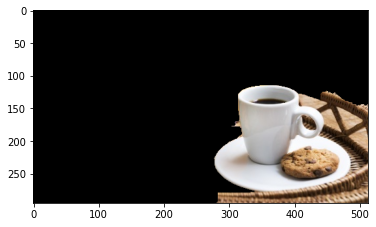

In [ ]:
gc(277,113,490,279, rgb_1, 15)

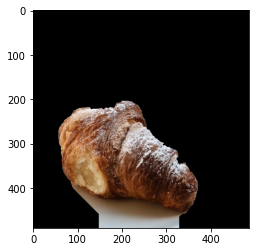

In [ ]:
rgb_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

gc(50,200, 364,443, rgb_2, 25)

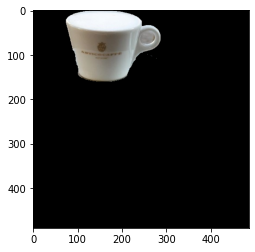

In [ ]:
gc(68,1, 283,162, rgb_2,5)

We load the image, create a similar mask image. We create fgdModel and bgdModel. We give the rectangle parameters. It’s all straight-forward. Let the algorithm run for 5 iterations. Mode should be cv2.GC_INIT_WITH_RECT since we are using rectangle. Then run the grabcut. It modifies the mask image. In the new mask image, pixels will be marked with four flags denoting background/foreground as specified above. So we modify the mask such that all 0-pixels and 2-pixels are put to 0 (ie background) and all 1-pixels and 3-pixels are put to 1(ie foreground pixels). Now our final mask is ready. Just multiply it with input image to get the segmented image.

## Spectral clustering

In [ ]:
import time

import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.transform import rescale

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.fixes import parse_version

def spectral_clustering_(image_gray, N_REGIONS, threshold_1, threshold_2):
  # these were introduced in skimage-0.14
  if parse_version(skimage.__version__) >= parse_version("0.14"):
      rescale_params = {"anti_aliasing": False, "multichannel": False}
  else:
      rescale_params = {}

  smoothened_img = gaussian_filter(image_gray, sigma=2)
  rescaled_img = rescale(smoothened_img, threshold_1, mode="reflect", **rescale_params)

  graph = image.img_to_graph(rescaled_img)

  beta = 10
  eps = 1e-6
  graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

  for assign_labels in ("kmeans", "discretize"):
    t0 = time.time()
    labels = spectral_clustering(
        graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=42
    )
    t1 = time.time()
    labels = labels.reshape(rescaled_img.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_img, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
  plt.show()
  resized_labels = rescale(labels, threshold_2, mode="reflect", **rescale_params)
  if threshold_1 == 0.2:
    resized_labels = resized_labels[:, :-2].astype(int)
  else:
    resized_labels = resized_labels[:, :-4].astype(int)
  return resized_labels

Spectral clustering: kmeans, 41.77s
Spectral clustering: discretize, 41.18s


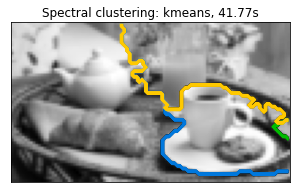

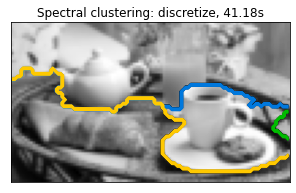

In [ ]:
resized_labels_1 = spectral_clustering_(gray_1, 4, 0.2, 5.0)

Spectral clustering: kmeans, 28.55s
Spectral clustering: discretize, 28.80s


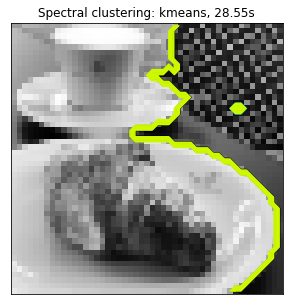

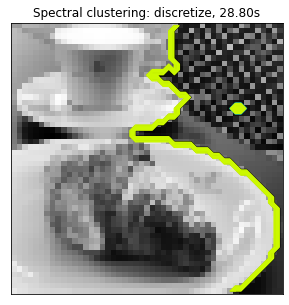

In [ ]:
resized_labels_2 = spectral_clustering_(gray_2, 3, 0.1, 10.0)

In [ ]:
are_sc_1, voi_sc_1 = metrics(label_im2, resized_labels_1)
are_sc_2, voi_sc_2 = metrics(label_im1, resized_labels_2)

## Agglomarative clustering

In [ ]:
def agglomarative_clustering(image_gray, n_clusters):
  scale_percent = 50 # percent of original size
  width = int(image_gray.shape[1] * scale_percent / 100)
  height = int(image_gray.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized_1 = cv2.resize(image_gray, dim, interpolation = cv2.INTER_AREA)

  # filter to reduce noise
  img = cv2.GaussianBlur(resized_1,(5,5), 3)
  img = otsu(img)

  # # flatten the image
  flat_image = img.reshape((-1,3))
  flat_image = np.float32(flat_image)

  from sklearn.cluster import AgglomerativeClustering

  fig, ax = plt.subplots(ncols=2, figsize=(30, 50))

  clustering = AgglomerativeClustering(n_clusters=n_clusters, compute_full_tree=False).fit(flat_image)
  labeled=clustering.labels_
  labeled.shape, img.shape

  # get number of segments
  segments = np.unique(labeled)
  print('Number of segments: ', segments.shape[0])

  # get the average color of each segment
  total = np.zeros((segments.shape[0], 3), dtype=float)
  count = np.zeros(total.shape, dtype=float)
  for i, label in enumerate(labeled):
      total[label] = total[label] + flat_image[i]
      count[label] += 1
  avg = total/count
  avg = np.uint8(avg)

  # cast the labeled image into the corresponding average color
  res = avg[labeled]
  result = res.reshape((img.shape))
  ax[0].imshow(img, cmap="gray")

  scale_percent = 200 # percent of original size
  if result.shape[1] != 243:
    width = int((result.shape[1]+0.5) * scale_percent / 100)
    height = int((result.shape[0]+0.5) * scale_percent / 100)
  else:
    width = int(result.shape[1] * scale_percent / 100)
    height = int(result.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  result_resized = cv2.resize(result, dim, interpolation = cv2.INTER_AREA)
  ax[1].imshow(result_resized, cmap="gray")
  return result_resized

Number of segments:  4
Number of segments:  3


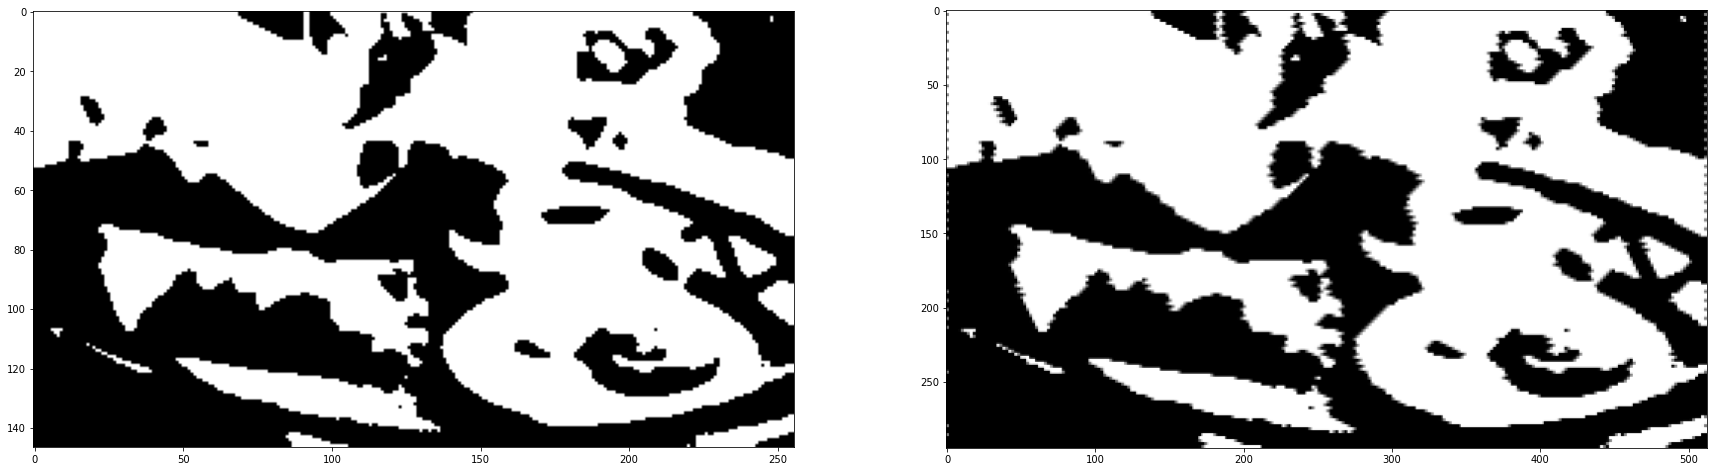

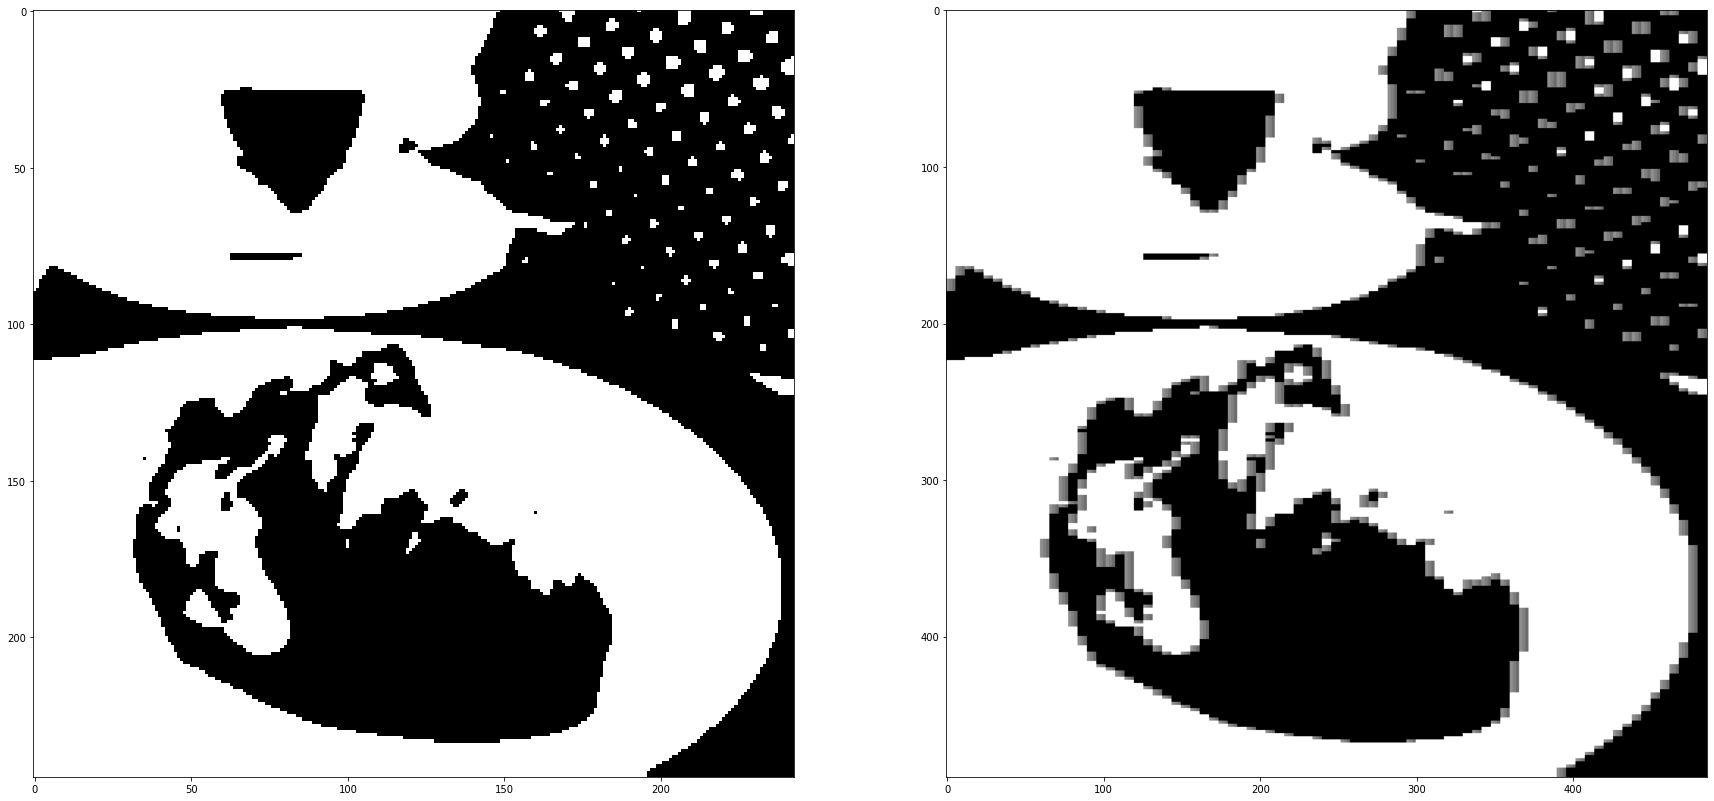

In [ ]:
result_resized_1 = agglomarative_clustering(gray_1, n_clusters=4)
result_resized_2 = agglomarative_clustering(gray_2, n_clusters=3)
are_agg_1, voi_agg_1 = metrics(label_im2, result_resized_1)
are_agg_2, voi_agg_2 = metrics(label_im1, result_resized_2)

## Mean shift

In [ ]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth

def mean_shift(image_gray):
  # filter to reduce noise
  img = cv2.GaussianBlur(image_gray,(5,5), 3)
  img = otsu(img)

  # # flatten the image
  flat_image = img.reshape((-1,3))
  flat_image = np.float32(flat_image)
  fig, ax = plt.subplots(ncols=2, figsize=(30, 50))

  # meanshift
  bandwidth = estimate_bandwidth(flat_image, quantile=0.2, n_samples=500)
  ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
  ms.fit(flat_image)
  labeled=ms.labels_


  # get number of segments
  segments = np.unique(labeled)
  print('Number of segments: ', segments.shape[0])

  # get the average color of each segment
  total = np.zeros((segments.shape[0], 3), dtype=float)
  count = np.zeros(total.shape, dtype=float)
  for i, label in enumerate(labeled):
      total[label] = total[label] + flat_image[i]
      count[label] += 1
  avg = total/count
  avg = np.uint8(avg)

  # cast the labeled image into the corresponding average color
  res = avg[labeled]
  result = res.reshape((img.shape))
  ax[0].imshow(img, cmap="gray")
  ax[1].imshow(result, cmap="gray")
  return result

Number of segments:  8
Number of segments:  8


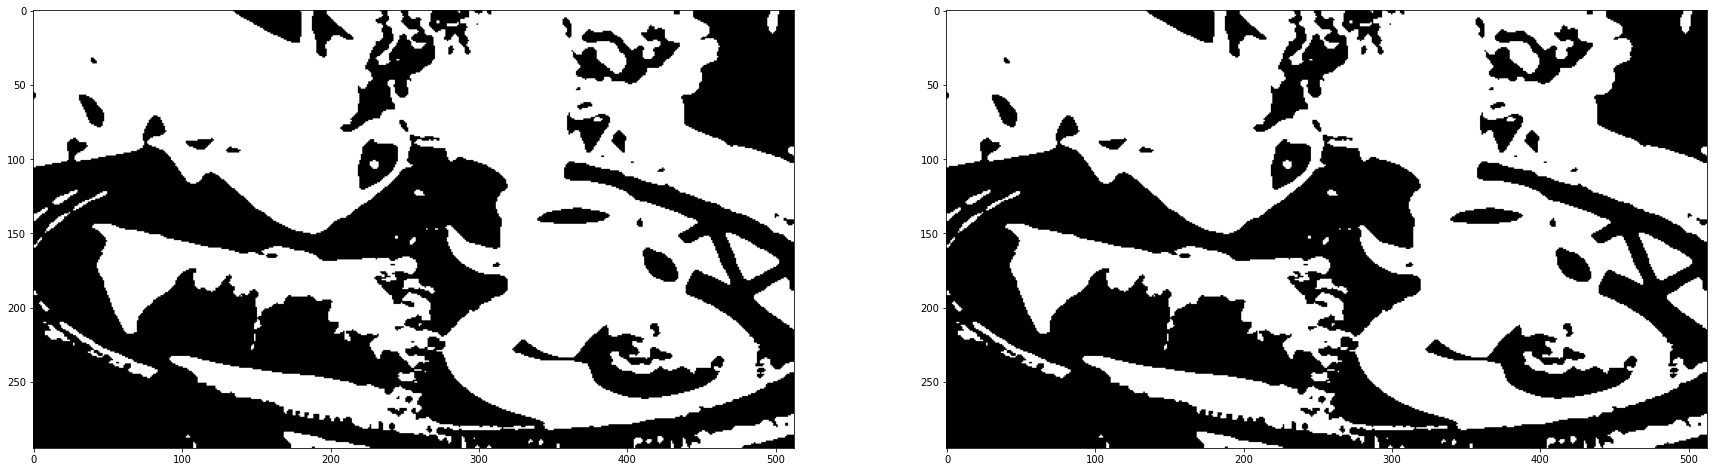

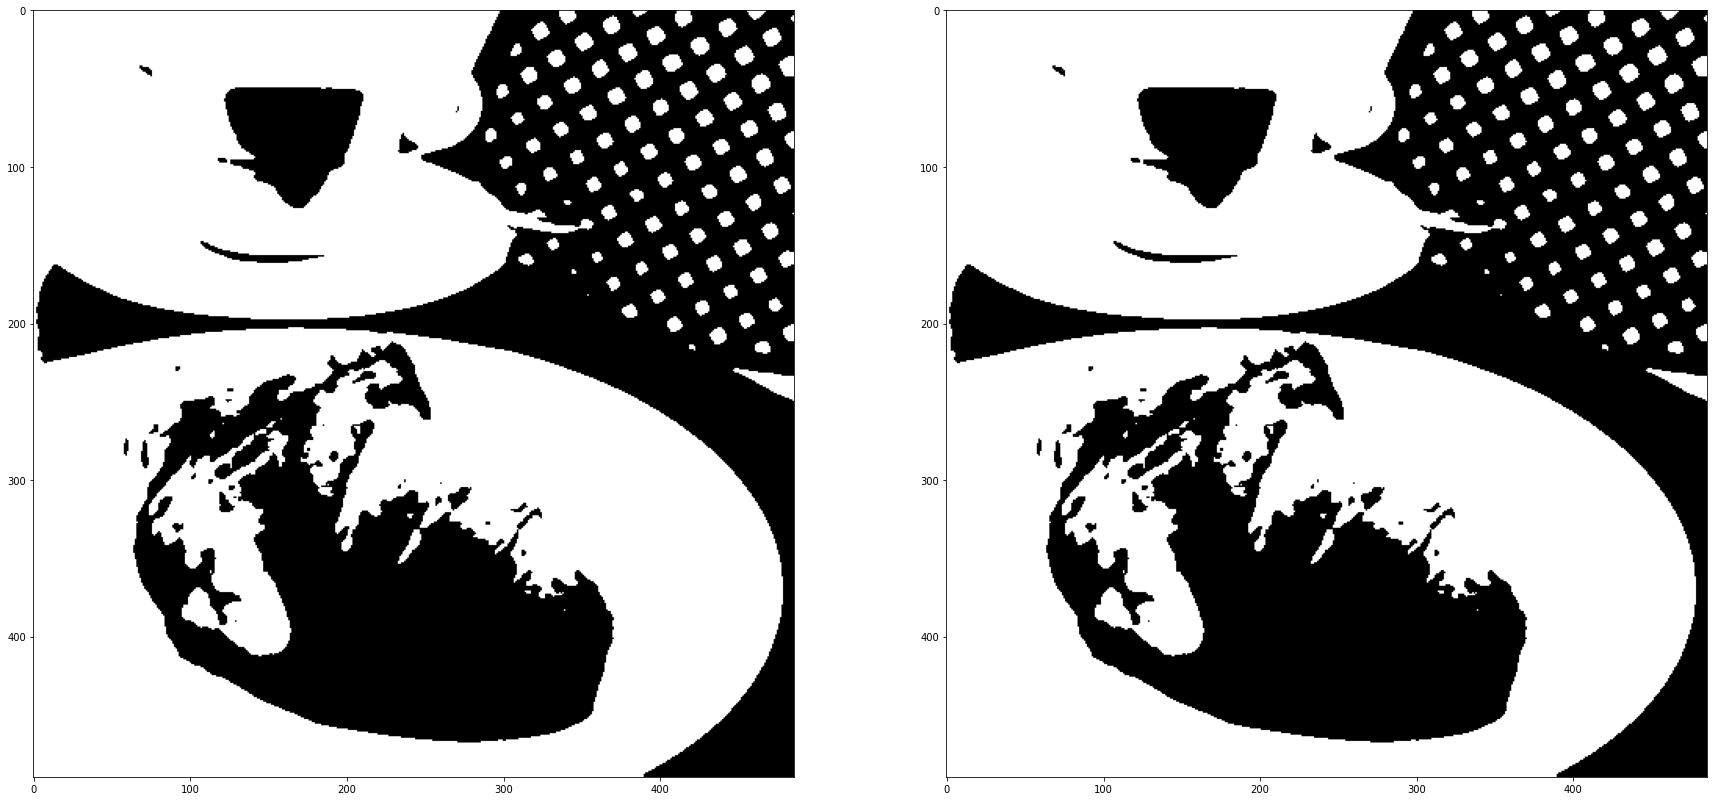

In [ ]:
labeled_1 = mean_shift(gray_1)
labeled_2 = mean_shift(gray_2)
are_msh_1, voi_msh_1 = metrics(label_im2, labeled_1)
are_msh_2, voi_msh_2 = metrics(label_im1, labeled_2)

**K-Means++**

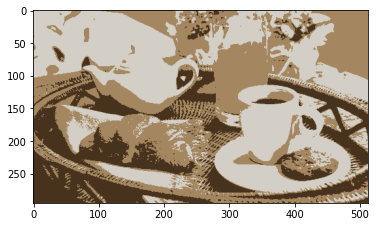

In [ ]:
image = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

segmented_image = segmented_data.reshape((image.shape))
 
plt.imshow(segmented_image)

are_km_1, voi_km_1 = metrics(label_im2, labels.reshape((295, 513)))


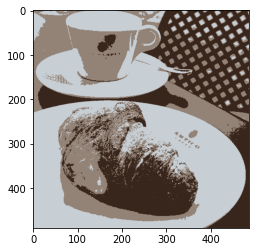

In [ ]:
image = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
k = 3
retval, labels_2, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels_2.flatten()]

segmented_image = segmented_data.reshape((image.shape))
 
plt.imshow(segmented_image)

are_km_2, voi_km_2 = metrics(label_im1, labels_2.reshape((490, 486)))


**Fuzzy K-Means**

In [ ]:
!pip install scikit-fuzzy

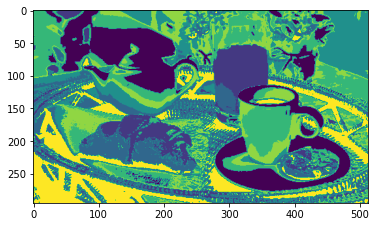

In [ ]:
from skfuzzy import cmeans

image = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
pixel_vals = image.reshape((-1,3)).T
pixel_vals = np.float32(pixel_vals)

y_pred = np.argmax(cmeans(pixel_vals, c=7, m=2, error=0.005, maxiter=1000)[1], axis=0)

segmented_image = y_pred.reshape((295,513))
 
plt.imshow(segmented_image)

are_fkm_1, voi_fkm_1 = metrics(label_im2, y_pred.reshape((295, 513)))

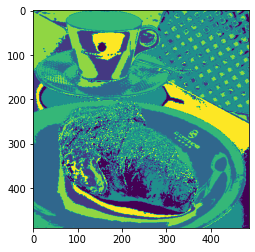

In [ ]:
from skfuzzy import cmeans

image = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
pixel_vals = image.reshape((-1,3)).T
pixel_vals = np.float32(pixel_vals)

y_pred_2 = np.argmax(cmeans(pixel_vals, c=7, m=2, error=0.005, maxiter=1000)[1], axis=0)

segmented_image = y_pred_2.reshape((490,486))
 
plt.imshow(segmented_image)

are_fkm_2, voi_fkm_2 = metrics(label_im1, y_pred_2.reshape((490, 486)))

In [ ]:
label_im1.shape

(490, 486)

## Metrics

**skimage.metrics.adapted_rand_error**(image_true=None, image_test=None, *, table=None, ignore_labels=(0,))

Returns
are float
The adapted Rand error; 
prec float
The adapted Rand precision: this is the number of pairs of pixels that have the same label in the test label image and in the true image, divided by the number in the test image.
rec float
The adapted Rand recall: this is the number of pairs of pixels that have the same label in the test label image and in the true image, divided by the number in the true image.

**skimage.metrics.variation_of_information**(image0=None, image1=None, *, table=None, ignore_labels=())[source]
Return symmetric conditional entropies associated with the VI. 

The variation of information is defined as VI(X,Y) = H(X|Y) + H(Y|X) If X is the ground-truth segmentation, then H(X|Y) can be interpreted as the amount of under-segmentation and H(X|Y) as the amount of over-segmentation. In other words, a perfect over-segmentation will have H(X|Y)=0 and a perfect under-segmentation will have H(Y|X)=0.

Returns
vindarray of float, shape (2,)
The conditional entropies of image1|image0 and image0|image1.

In [ ]:
import pandas as pd

ff1=[]
ff1.append(floodfill_are_1[0][0])
ff1.append(floodfill_are_1[0][1])
ff1.append(floodfill_are_1[0][2])
ff1.append(floodfill_voi_1[0][0])
ff1.append(floodfill_voi_1[0][1])
ff2=[]
ff2.append(floodfill_are_2[0][0])
ff2.append(floodfill_are_2[0][1])
ff2.append(floodfill_are_2[0][2])
ff2.append(floodfill_voi_2[0][0])
ff2.append(floodfill_voi_2[0][1])
w1=[]
w1.append(watershed_are_1[0][0])
w1.append(watershed_are_1[0][1])
w1.append(watershed_are_1[0][2])
w1.append(watershed_voi_1[0][0])
w1.append(watershed_voi_1[0][1])
w2=[]
w2.append(watershed_are_2[0][0])
w2.append(watershed_are_2[0][1])
w2.append(watershed_are_2[0][2])
w2.append(watershed_voi_2[0][0])
w2.append(watershed_voi_2[0][1])
sc1=[]
sc1.append(are_sc_1[0][0])
sc1.append(are_sc_1[0][1])
sc1.append(are_sc_1[0][2])
sc1.append(voi_sc_1[0][0])
sc1.append(voi_sc_1[0][1])
sc2=[]
sc2.append(are_sc_2[0][0])
sc2.append(are_sc_2[0][1])
sc2.append(are_sc_2[0][2])
sc2.append(voi_sc_2[0][0])
sc2.append(voi_sc_2[0][1])
agg1=[]
agg1.append(are_agg_1[0][0])
agg1.append(are_agg_1[0][1])
agg1.append(are_agg_1[0][2])
agg1.append(voi_agg_1[0][0])
agg1.append(voi_agg_1[0][1])
agg2=[]
agg2.append(are_agg_2[0][0])
agg2.append(are_agg_2[0][1])
agg2.append(are_agg_2[0][2])
agg2.append(voi_agg_2[0][0])
agg2.append(voi_agg_2[0][1])
msh1=[]
msh1.append(are_msh_1[0][0])
msh1.append(are_msh_1[0][1])
msh1.append(are_msh_1[0][2])
msh1.append(voi_msh_1[0][0])
msh1.append(voi_msh_1[0][1])
msh2=[]
msh2.append(are_msh_2[0][0])
msh2.append(are_msh_2[0][1])
msh2.append(are_msh_2[0][2])
msh2.append(voi_msh_2[0][0])
msh2.append(voi_msh_2[0][1])
km1=[]
km1.append(are_km_1[0][0])
km1.append(are_km_1[0][1])
km1.append(are_km_1[0][2])
km1.append(voi_km_1[0][0])
km1.append(voi_km_1[0][1])
km2=[]
km2.append(are_km_2[0][0])
km2.append(are_km_2[0][1])
km2.append(are_km_2[0][2])
km2.append(voi_km_2[0][0])
km2.append(voi_km_2[0][1])
fkm1 = []
fkm1.append(are_fkm_1[0][0])
fkm1.append(are_fkm_1[0][1])
fkm1.append(are_fkm_1[0][2])
fkm1.append(voi_fkm_1[0][0])
fkm1.append(voi_fkm_1[0][1])
fkm2 = []
fkm2.append(are_fkm_2[0][0])
fkm2.append(are_fkm_2[0][1])
fkm2.append(are_fkm_2[0][2])
fkm2.append(voi_fkm_2[0][0])
fkm2.append(voi_fkm_2[0][1])
# print(len(ff1))
# print(len(ff2))
# print(len(w1))
# print(len(w2))


metrics_=['adapted_rand_error','adapted Rand precision', 'adapted Rand recall','variation_of_information 1', 'variation_of_information 2']
m_df = {'Metrics':metrics_,
        "Flood fill 1": ff1,
        "Flood fill 2": ff2,
        "Watershed 1": w1,
        "Watershed 2": w2,
        "Spectral clustering 1": sc1,
        "Spectral clustering 2": sc2,
        "Agglomarative clustering 1": agg1,
        "Agglomarative clustering 2": agg2,
        "Mean shift 1": msh1,
        "Mean shift 2": msh2,
        "K-means++ 1": km1,
        "K-means++ 2": km2,
        "Fuzzy K-Means 1": fkm1,
        "Fuzzy K-Means 2": fkm2}

df_metrics = pd.DataFrame(data=m_df)

df_metrics

Metrics  Flood fill 1  ...  Fuzzy K-Means 1  Fuzzy K-Means 2
0          adapted_rand_error      0.171207  ...         0.610341         0.566264
1      adapted Rand precision      0.709411  ...         0.275437         0.309037
2         adapted Rand recall      0.996485  ...         0.665735         0.727145
3  variation_of_information 1      3.274345  ...         1.762890         1.686753
4  variation_of_information 2      0.976063  ...         1.380251         1.224485

[5 rows x 15 columns]

# Висновки

Краще порівнювати методи за adadpted_rand метрикою, оскільки вона складаєтся з помилки, precision, recall, що дозволяє повністю оцінити якість метода.

Найкращий метод - Flood fill.

Найгірший метод - Watershed.